# Yeast induction timecourse

This notebook demonstrates a real-world multidimensional analysis example.  The yeast strain responds to the small molecule isopentyladenine (IP) by expressing green fluorescent protein (GFP), which we measure using a flow cytometer in the FITC-A channel.

This experiment was designed to determine the dynamics of the IP --> GFP response.  So, we induced several yeast cultures with different amounts of IP, then took readings on the cytometer every 30 minutes for 8 hours.  The outline of the experimental setup is below.

![Induction experiment](_images/yeast_experiment.png)

---

Import `cytoflow`.

In [2]:
import cytoflow as flow

# if your figures are too big or too small, you can scale them by changing matplotlib's DPI
import matplotlib
matplotlib.rc('figure', dpi = 160)

In this instance, the amount of IP and the time is actually encoded in the FCS filename.  So, use `glob` to iterate through all the FCS files in the directory and `re` extract the IP concentration and timepoint from the filename. 

NB. Many FCS files already have a channel named "Time" which encodes how long since the acquisition start an event was collected.  So it is inadvisable to use "Time" as a condition name.

In [3]:
# In this instance, I have encoded the experimental conditions in the filenames.
# So, use glob to get the files and parse the conditions back out.

import glob, re
tubes = []

for f in glob.glob("*.fcs"):
    r = re.search("IP_(.*?)_Minutes_(.*?)\.fcs", f)
    ip = r.group(1)
    minutes = r.group(2)
    
    tube = flow.Tube(file = f, conditions = {"IP" : float(ip), "Minutes" : int(minutes)})
    tubes.append(tube)
    
ex = flow.ImportOp(tubes = tubes,
                   conditions = {"IP" : "float",
                                 "Minutes" : "int"},
                   events = 1000).apply()

Take a quick look at the morphological parameters.

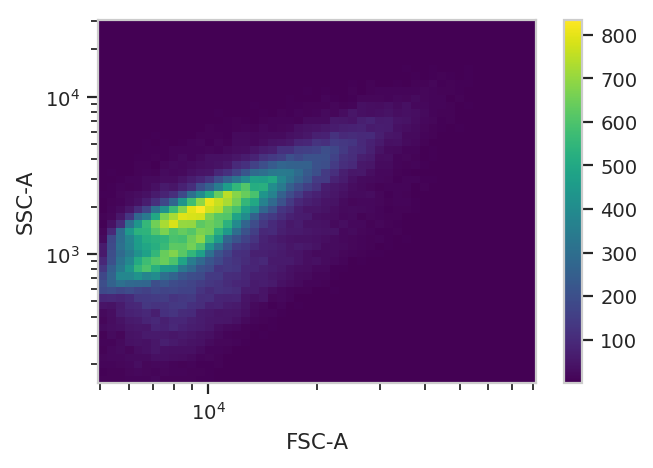

In [4]:
flow.DensityView(xchannel = "FSC-A",
                 xscale = "log",
                 ychannel = "SSC-A",
                 yscale = "log").plot(ex)

There does seem to be a little bit of structure here, but in general the distribution is quite tight.  So, we'll use a 2D gaussian mixture model to get single cells, keeping the events that are within two standard deviations of the distribution mean.

In [5]:
gm = flow.GaussianMixtureOp(name = "GM",
                            channels = ['FSC-A', 'SSC-A'],
                            scale = {'FSC-A' : 'log',
                                     'SSC-A' : 'log'},
                            num_components = 1,
                            sigma = 2)
gm.estimate(ex)
ex_gm = gm.apply(ex)


A diagnostic plot of the GMM.

/home/brian/src/cytoflow/cytoflow/operations/base_op_views.py:341: CytoflowViewWarning: Setting 'huefacet' to 'GM_1'


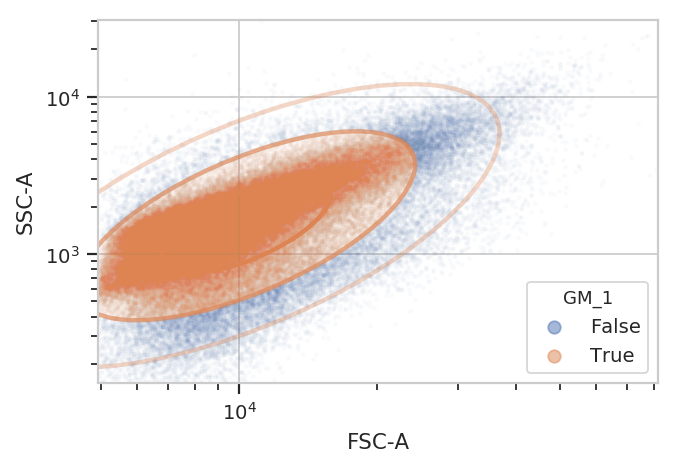

In [6]:
gm.default_view().plot(ex_gm, alpha = 0.02)

Yep, that looks fine.  Now compute the geometric mean in the FITC-A channel to see how GFP expression varies with IP concentration and time since induction.

In [7]:
ex_stat = flow.ChannelStatisticOp(name = 'GFP',
                                  channel = 'FITC-A',
                                  function = flow.geom_mean,
                                  by = ['IP', 'Minutes'],
                                  subset = 'GM_1 == True').apply(ex_gm)

And plot it.  Could you use `pandas` and `seaborn` to do this instead?  Absolutely.

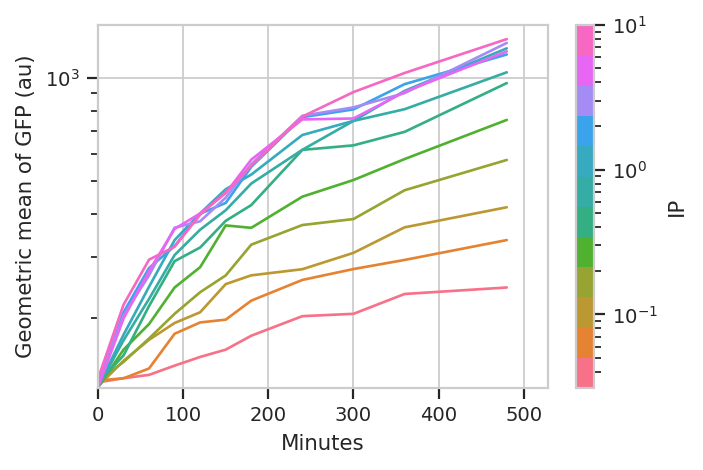

In [8]:
flow.Stats1DView(statistic = ('GFP', 'geom_mean'),
                 variable = 'Minutes',
                 scale = 'log',
                 huefacet = 'IP',
                 huescale = 'log').plot(ex_stat,
                                        ylabel = 'Geometric mean of GFP (au)')

A geometric mean is only an appropriate summary statistic if the unimodal in log space.  Is this actually true?  Let's look at the histogram of each [IP]/time combination to find out.

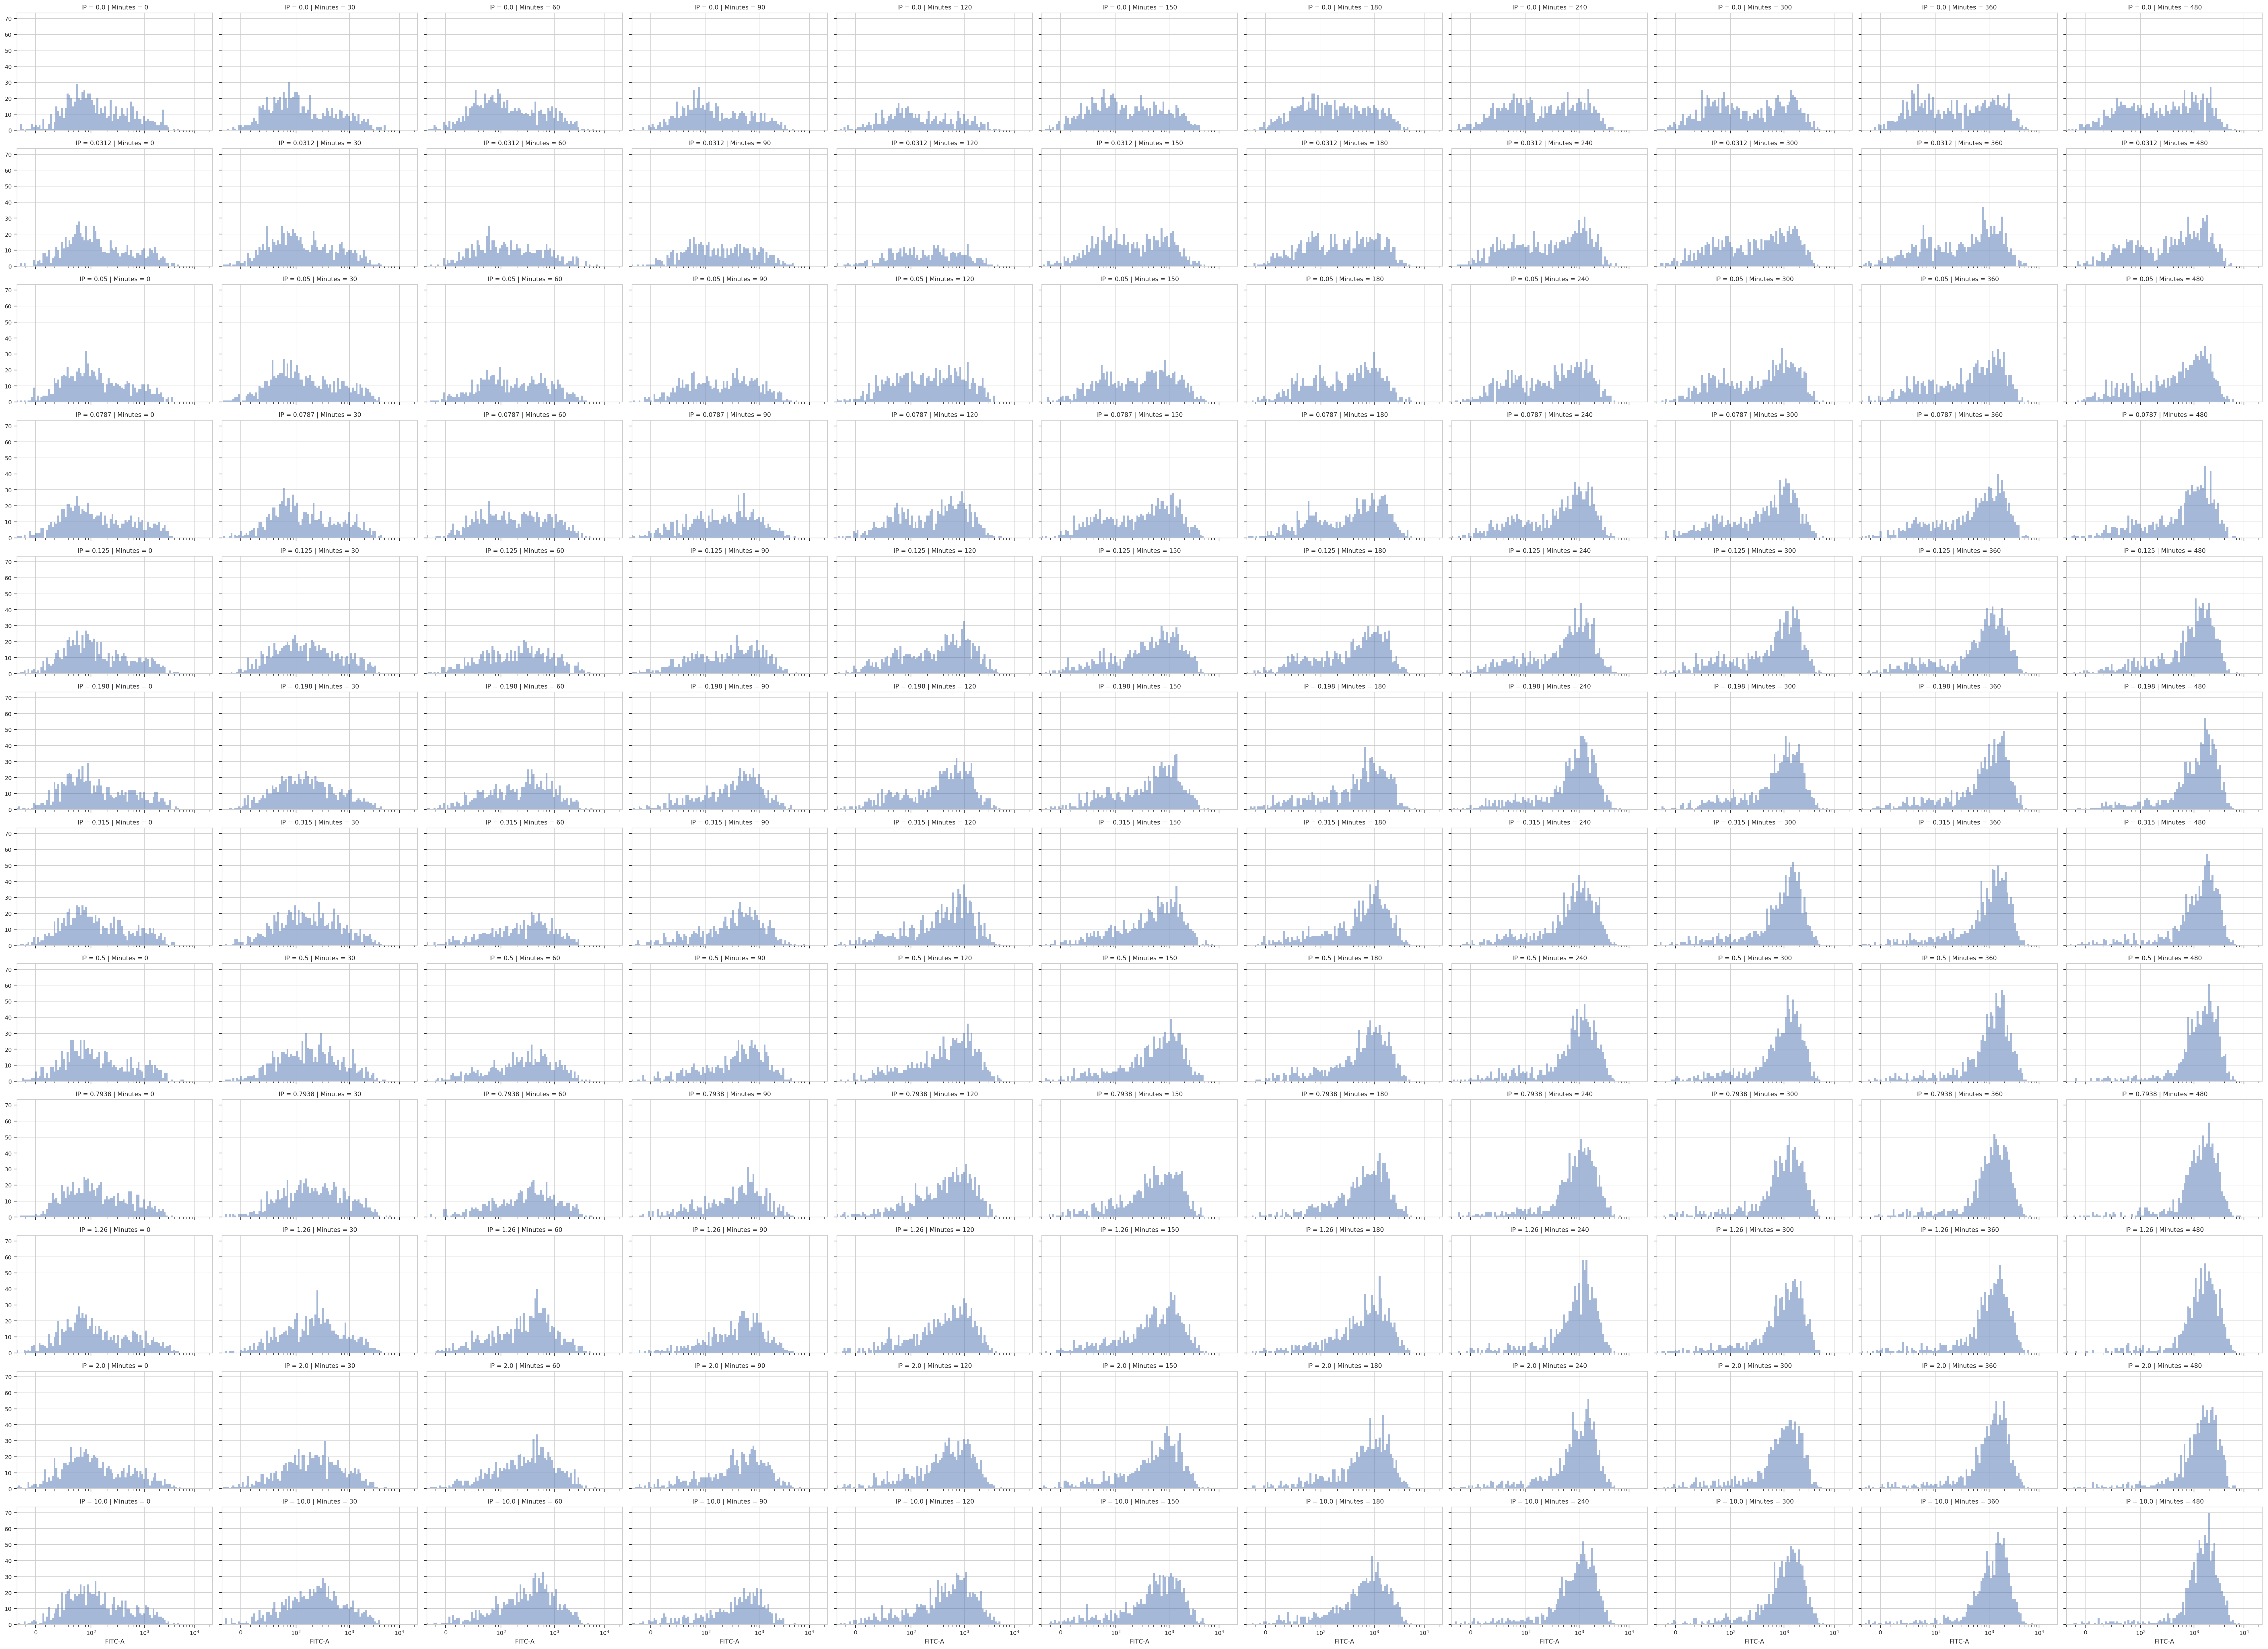

In [9]:
flow.HistogramView(channel = 'FITC-A',
                   xfacet = 'Minutes',
                   yfacet = 'IP',
                   scale = 'logicle',
                   subset = 'GM_1 == True').plot(ex_gm)

Wow!  That's a lot of plots, and reading the axes is impossible.  I maybe could use `matplotlib.pyplot` to change the plot parameters and get something useful, but instead let's put [IP] on the hue facet instead of the Y facet.  Then, we can wrap the X facet into three columns and actually see each plot.

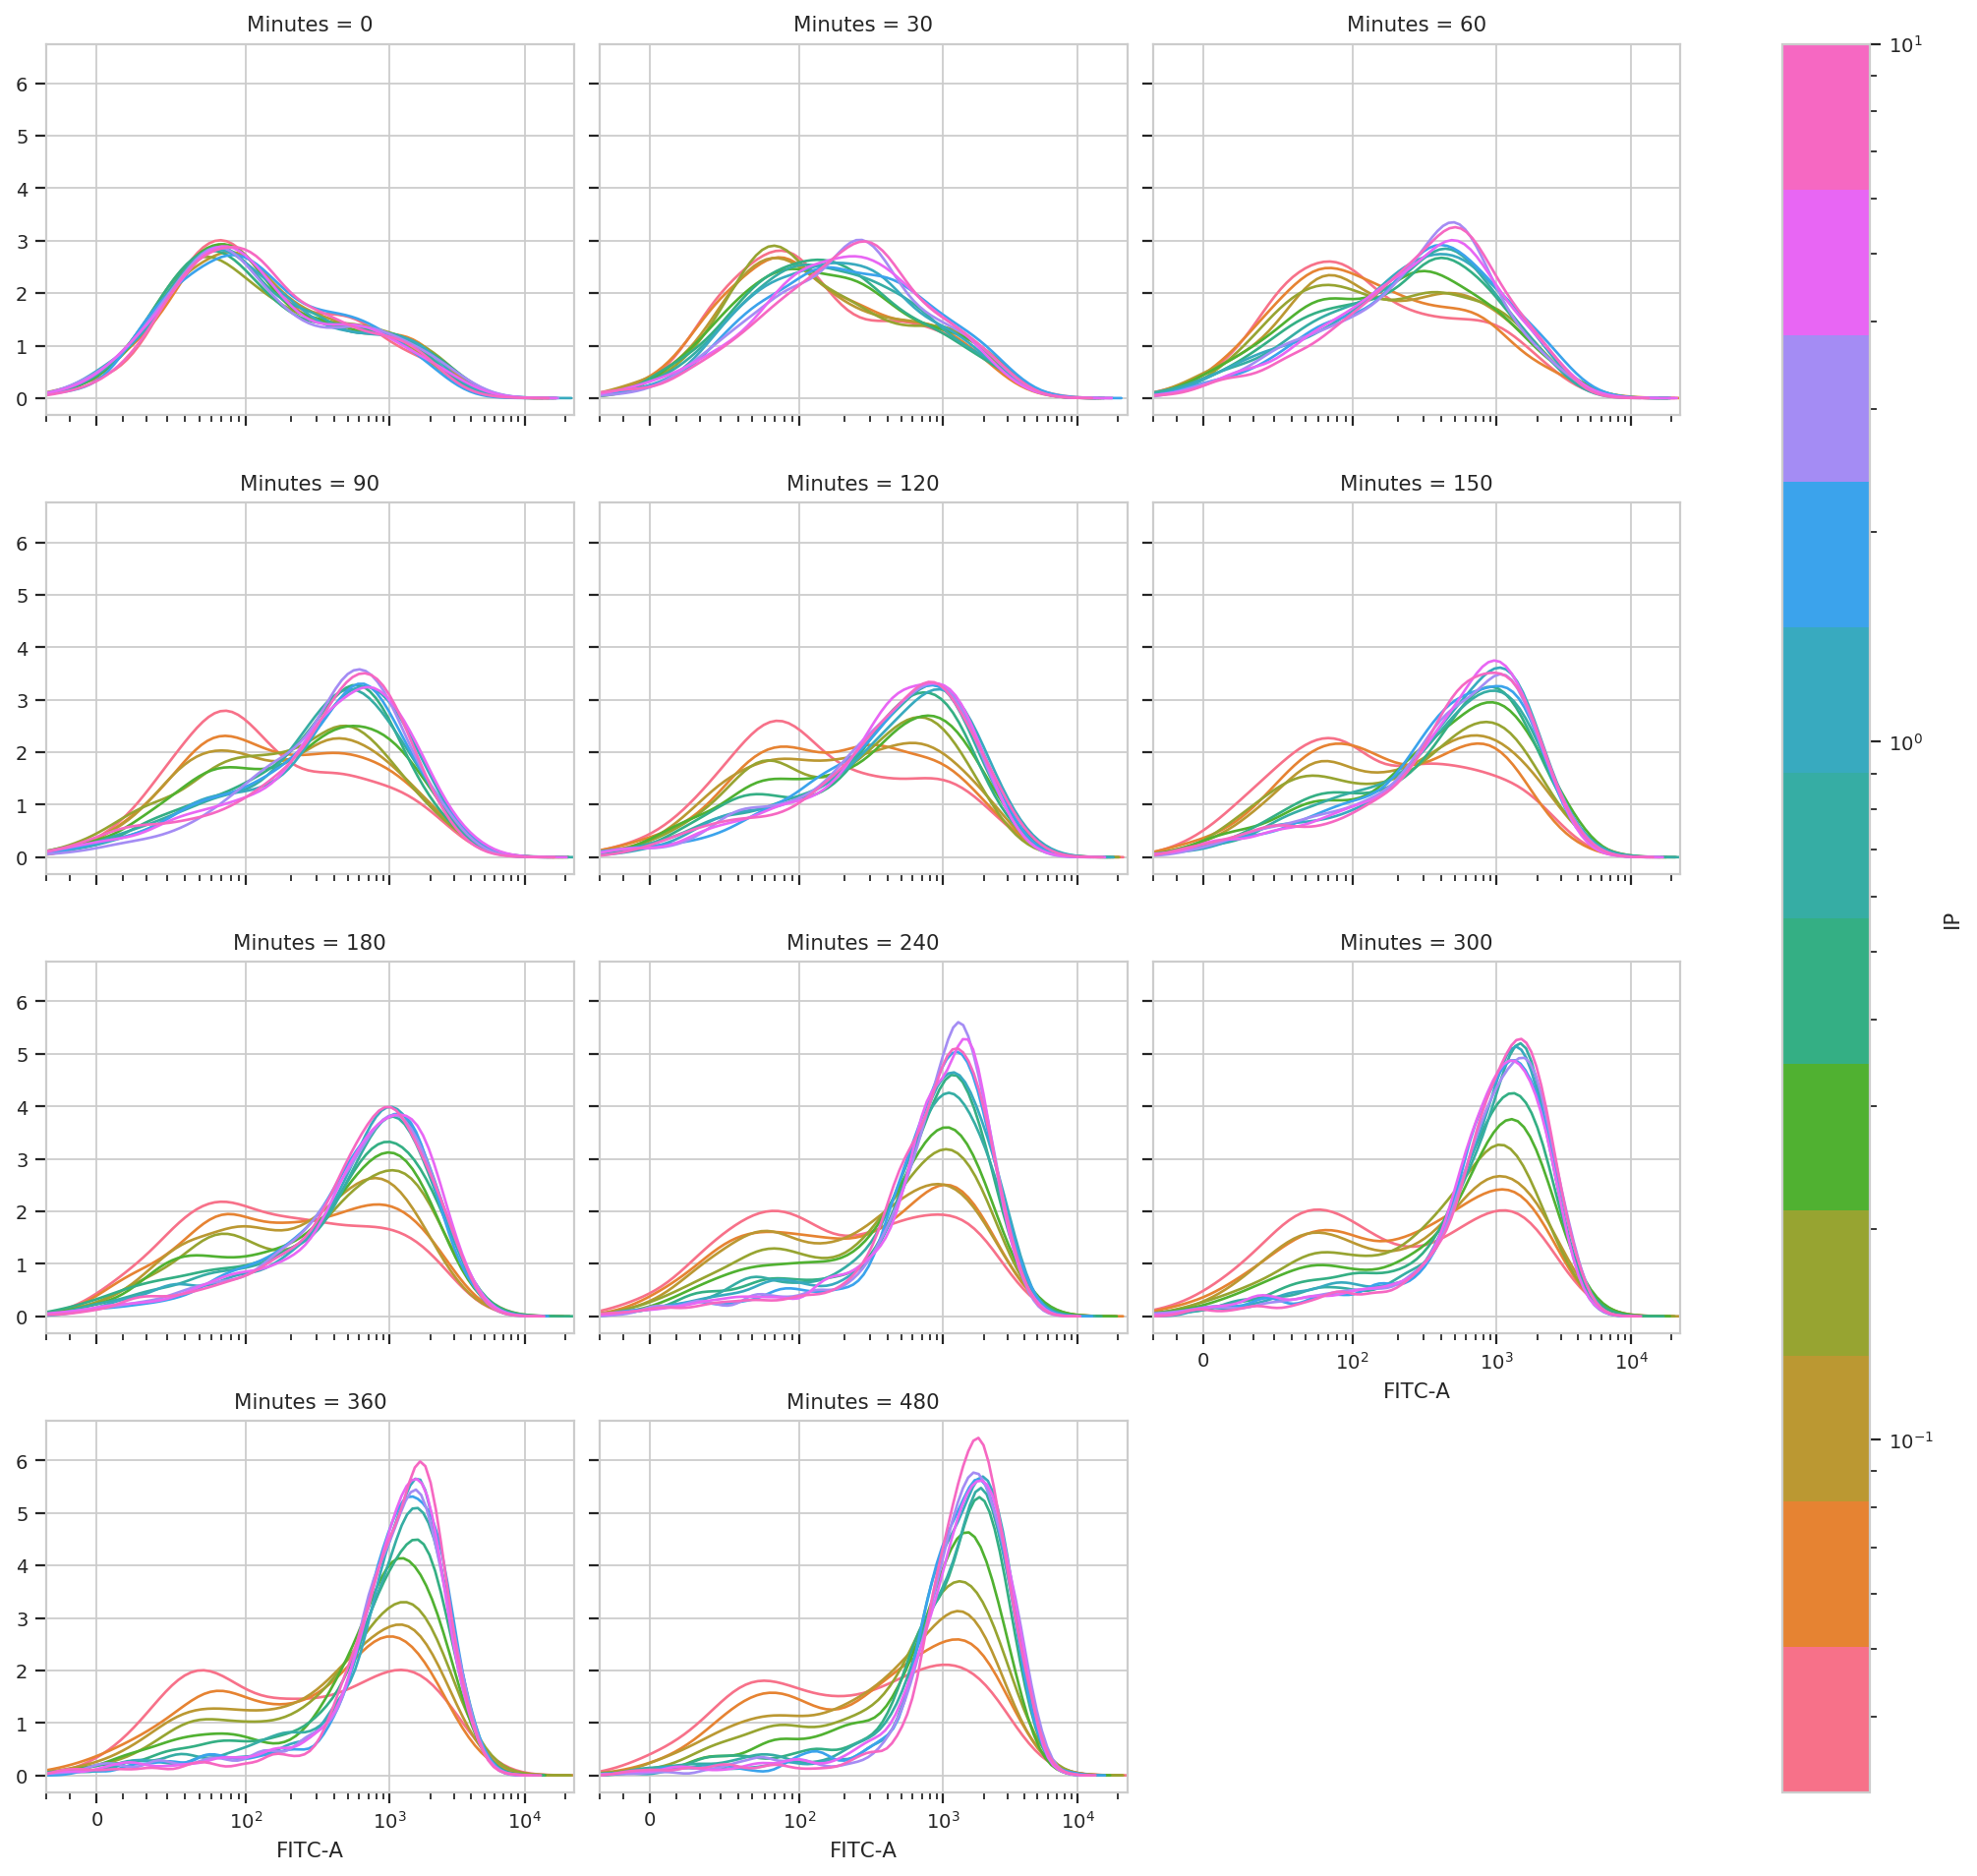

In [10]:
flow.Kde1DView(channel = 'FITC-A',
               xfacet = 'Minutes',
               huefacet = 'IP',
               scale = 'logicle',
               huescale = 'log',
               subset = 'GM_1 == True').plot(ex_gm, col_wrap = 3, shade = False)

This is very, very interesting!  There appears to be significant structure to this data.  It's almost as if there are two populations, one that is "off" and one that is "on" -- and that higher [IP] influences the rate at which cells switch from the off population to the on population.

We can model this mixture of gaussians using a class we've already seen, `GaussianMixtureOp`.  We'll estimate two components, and we won't specify `sigma`.  We'll also say `by = ['IP', 'Minutes']` to fit a different model to each unique combination of [IP] and time.

In [11]:
gm_fitc = flow.GaussianMixtureOp(name = "GM_FITC",
                                 channels = ['FITC-A'],
                                 scale = {'FITC-A' : 'log'},
                                 by = ['IP', 'Minutes'],
                                 num_components = 2)
gm_fitc.estimate(ex_gm, subset = 'GM_1 == True')

In [12]:
ex_stat_2 = gm_fitc.apply(ex_gm)

Most data-driven operations add summary statistics to the experiment as well.  Let's have a look at which statistics are defined for this experiment.

In [13]:
ex_stat_2.statistics.keys()

dict_keys([('GM', 'mean'), ('GM', 'sigma'), ('GM', 'interval'), ('GM', 'correlation'), ('GM_FITC', 'mean'), ('GM_FITC', 'sigma'), ('GM_FITC', 'interval'), ('GM_FITC', 'proportion')])

The statistic `('GM_FITC', 'proportion')` looks promising.

In [14]:
ex_stat_2.statistics[('GM_FITC', 'proportion')]

IP       Minutes  Component
0.0000   0        1            0.689475
                  2            0.310525
         30       1            0.689704
                  2            0.310296
         60       1            0.667829
                  2            0.332171
         90       1            0.677261
                  2            0.322739
         120      1            0.651504
                  2            0.348496
         150      1            0.573523
                  2            0.426477
         180      1            0.585170
                  2            0.414830
         240      1            0.576592
                  2            0.423408
         300      1            0.589542
                  2            0.410458
         360      1            0.531817
                  2            0.468183
         480      1            0.527385
                  2            0.472615
0.0312   0        1            0.763097
                  2            0.236903
         30 

Great, we've got the proportions of component 1 and 2, at each IP concentration and timepoint.  Plot the proportion in component 2 with "Minutes" on the X axis and "IP" on the hue facet.

/home/brian/src/cytoflow/cytoflow/views/base_views.py:751: CytoflowViewWarning: Only one value for level Component; dropping it.


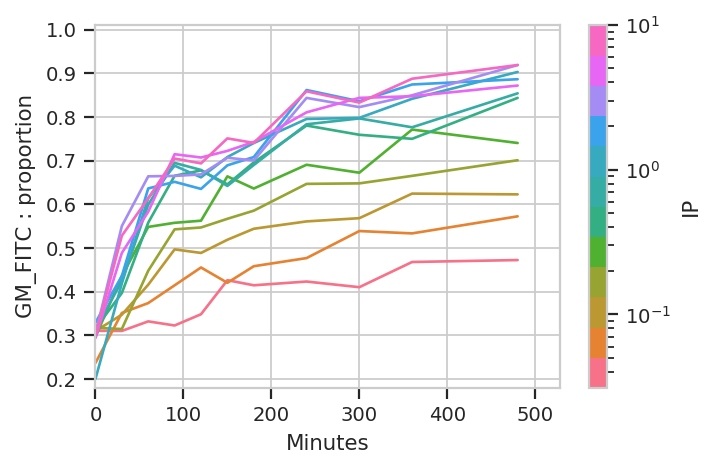

In [15]:
flow.Stats1DView(statistic = ("GM_FITC", "proportion"),
                 variable = "Minutes",
                 huefacet = "IP",
                 huescale = "log",
                 subset = "Component == 2").plot(ex_stat_2)

Ignore the "jagged" nature of the plot.  The original data set is hundreds of megabytes big, and in that data set the curves are much smoother (-;  

The important question is: is this any different than the geometric mean?  Let's re-plot the geometric mean plot so we can look at both.

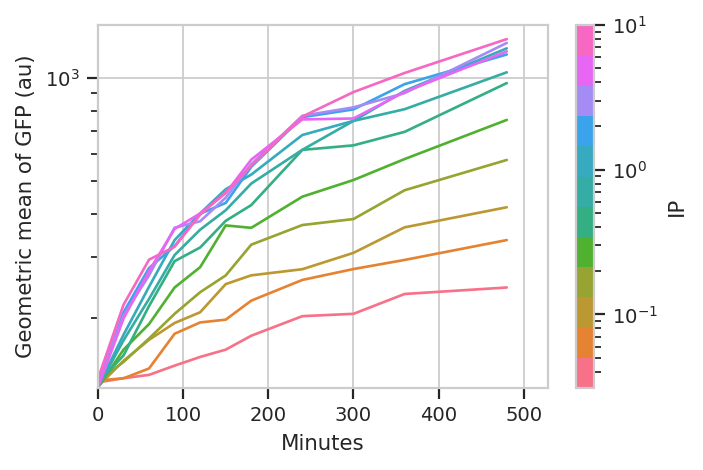

In [16]:
flow.Stats1DView(statistic = ('GFP', 'geom_mean'),
                 variable = 'Minutes',
                 scale = 'log',
                 huefacet = 'IP',
                 huescale = 'log').plot(ex_stat,
                                        ylabel = 'Geometric mean of GFP (au)')

I think those dynamics look significantly different.  For one thing, the mixture model "saturates" much more quickly -- both in time and in [IP].  The geometric mean model indicates saturation at about 5 uM, while the mixture model seems to saturate one or two steps earlier.  Things also stop changing quite as dramatically by about 240 minutes, whereas the geometric mean hasn't reached anything like a steady state by 480 minutes (the end of the experiment.)

---

I hope this has demonstrated a non-trivial insight into the dynamics of this biological system that are gained by looking at it through a quantitative lens, with some machine learning thrown in there as well.